## Exercise 2

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space

In [32]:
# --- CONFIGURAZIONE DEL SISTEMA (Problema 1 & 2) ---
# Definizione dei nodi e mappatura indici
nodes = ['o', 'a', 'b', 'c', 'd']
node_idx = {n: i for i, n in enumerate(nodes)}
num_nodes = len(nodes)

# Matrice dei tassi di transizione (Lambda) ricostruita dal testo/grafo
# Righe/Col: o, a, b, c, d
# Lambda[i, j] è il tasso da i a j
Lambda = np.zeros((num_nodes, num_nodes))

# Inserimento tassi (basato su matrice eq (1) e Fig 1)
# o -> a (2/5), o -> b (1/5)
Lambda[node_idx['o'], node_idx['a']] = 0.4
Lambda[node_idx['o'], node_idx['b']] = 0.2

# a -> b (3/4), a -> c (1/4)
Lambda[node_idx['a'], node_idx['b']] = 0.75
Lambda[node_idx['a'], node_idx['c']] = 0.25

# b -> o (1/2), b -> c (1/2)
Lambda[node_idx['b'], node_idx['o']] = 0.5
Lambda[node_idx['b'], node_idx['c']] = 1/3

# c -> b (1/3), c -> d (2/3)
Lambda[node_idx['c'], node_idx['b']] = 1/3
Lambda[node_idx['c'], node_idx['d']] = 2/3

# d -> a (1/3), d -> c (1/3)
Lambda[node_idx['d'], node_idx['a']] = 1/3
Lambda[node_idx['d'], node_idx['c']] = 1/3

# Calcolo tasso di uscita totale per ogni nodo (omega)
omega = np.sum(Lambda, axis=1)

# Matrice di probabilità di salto (P) per il "next hop"
P = np.linalg.inv(np.diag(omega)) @ Lambda

# --- CALCOLO TEORICO (Stationary Distribution) ---
# Generatore Q = Lambda - diag(omega)
Q = Lambda - np.diag(omega)
# Risolviamo pi * Q = 0  => Q.T * pi.T = 0
# Usiamo null_space di scipy per trovare il kernel
pi_basis = null_space(Q.T)
pi_theoretical = pi_basis[:, 0] / np.sum(pi_basis[:, 0]) # Normalizzazione
# Assicuriamoci che siano positivi
pi_theoretical = np.abs(pi_theoretical)

print("--- ANALISI TEORICA ---")
print("Tassi di uscita (omega):", dict(zip(nodes, np.round(omega, 3))))
print("Distribuzione stazionaria (pi):", dict(zip(nodes, np.round(pi_theoretical, 3))))
expected_return_a = 1 / (pi_theoretical[node_idx['a']] * omega[node_idx['a']])
print(f"Tempo di ritorno teorico atteso per 'a': {expected_return_a:.4f}")
print("-" * 30)

--- ANALISI TEORICA ---
Tassi di uscita (omega): {'o': np.float64(0.6), 'a': np.float64(1.0), 'b': np.float64(0.833), 'c': np.float64(1.0), 'd': np.float64(0.667)}
Distribuzione stazionaria (pi): {'o': np.float64(0.217), 'a': np.float64(0.149), 'b': np.float64(0.261), 'c': np.float64(0.186), 'd': np.float64(0.186)}
Tempo di ritorno teorico atteso per 'a': 6.7083
------------------------------


In [33]:
# --- PARTE A: PARTICLE PERSPECTIVE (Indipendenti) ---
def simulate_particle_return_time(start_node_idx, n_particles):
    """
    Simula N particelle indipendenti che partono da start_node.
    Restituisce la lista dei tempi di ritorno.
    """
    return_times = []
    
    for _ in range(n_particles):
        current_node = start_node_idx
        time_elapsed = 0.0
        has_left = False
        
        while True:
            # 1. Determina tempo di permanenza (Exp(omega_i))
            rate = omega[current_node]
            dt = np.random.exponential(1/rate)
            time_elapsed += dt
            
            # 2. Determina prossimo nodo basandosi su P
            next_node = np.random.choice(num_nodes, p=P[current_node])
            
            # Logica ritorno: deve lasciare il nodo e poi tornare
            if current_node == start_node_idx:
                if has_left: 
                    # È tornato! (Nota: time_elapsed include l'attesa prima di entrare qui? 
                    # No, include l'attesa nel nodo corrente PRIMA di saltare a next_node)
                    # Se next_node è start_node, è un ritorno.
                    pass
            
            prev_node = current_node
            current_node = next_node
            
            if prev_node == start_node_idx:
                has_left = True
            
            # Se siamo nel nodo target ed eravamo già usciti
            if current_node == start_node_idx and has_left:
                return_times.append(time_elapsed)
                break
                
    return np.array(return_times)

print("\n--- SIMULAZIONE A: PARTICLE PERSPECTIVE ---")
N_particles = 100
return_times = simulate_particle_return_time(node_idx['a'], N_particles)
avg_return_time = np.mean(return_times)
print(f"Numero particelle: {N_particles}")
print(f"Tempo medio di ritorno simulato (start a -> ... -> a): {avg_return_time:.4f}")
print(f"Confronto con teorico ({expected_return_a:.4f}): {'Vicino' if abs(avg_return_time - expected_return_a) < 1.0 else 'Distante'}")



--- SIMULAZIONE A: PARTICLE PERSPECTIVE ---
Numero particelle: 100
Tempo medio di ritorno simulato (start a -> ... -> a): 6.5914
Confronto con teorico (6.7083): Vicino


In [34]:
# --- PARTE B: NODE PERSPECTIVE (Gillespie Algorithm) ---
def simulate_node_perspective(start_dist, total_time, n_particles):
    """
    Simula il sistema aggregato.
    start_dist: array con conteggi iniziali per nodo [n_o, n_a, ...]
    """
    counts = np.array(start_dist, dtype=int)
    current_time = 0.0
    
    # Per il plotting
    times = [0.0]
    history = [counts.copy()]
    
    while current_time < total_time:
        # 1. Calcola tassi totali per ogni nodo: rate_i = n_i * omega_i
        node_rates = counts * omega
        total_system_rate = np.sum(node_rates)
        
        if total_system_rate == 0:
            break # Nessuna particella si muove più (impossibile qui dato il grafo chiuso)
            
        # 2. Tempo al prossimo evento (Esponenziale globale)
        # Nota: Hint suggerisce "System-wide clock". Questo è l'approccio Gillespie standard.
        dt = np.random.exponential(1 / total_system_rate)
        current_time += dt
        
        if current_time > total_time:
            break
            
        # 3. Scegli QUALE nodo muove una particella (prop. al suo rate)
        source_node = np.random.choice(num_nodes, p=node_rates/total_system_rate)
        
        # 4. Scegli DOVE va la particella
        target_node = np.random.choice(num_nodes, p=P[source_node])
        
        # Aggiorna stati
        counts[source_node] -= 1
        counts[target_node] += 1
        
        # Salva dati
        times.append(current_time)
        history.append(counts.copy())
        
    return np.array(times), np.array(history)

print("\n--- SIMULAZIONE B: NODE PERSPECTIVE ---")
initial_counts = [0, 100, 0, 0, 0] # Tutti in 'a'
T_max = 60
times, history = simulate_node_perspective(initial_counts, T_max, 100)

final_counts = history[-1]
expected_counts = pi_theoretical * 100

print(f"Conteggi finali simulati (t={T_max}):")
print(dict(zip(nodes, final_counts)))
print("Conteggi teorici stazionari (N * pi):")
print(dict(zip(nodes, np.round(expected_counts, 1))))


--- SIMULAZIONE B: NODE PERSPECTIVE ---
Conteggi finali simulati (t=60):
{'o': np.int64(25), 'a': np.int64(20), 'b': np.int64(25), 'c': np.int64(13), 'd': np.int64(17)}
Conteggi teorici stazionari (N * pi):
{'o': np.float64(21.7), 'a': np.float64(14.9), 'b': np.float64(26.1), 'c': np.float64(18.6), 'd': np.float64(18.6)}



Grafico salvato come 'homework2_simulation.pdf'


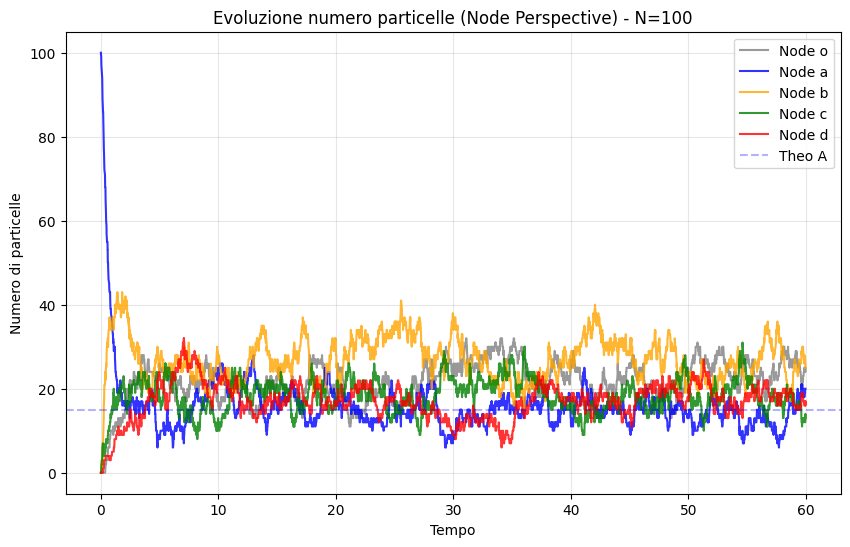

In [35]:
# --- PLOTTING ---
plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times, history[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)

plt.axhline(y=expected_counts[node_idx['a']], color='blue', linestyle='--', alpha=0.3, label='Theo A')
# (Opzionale: aggiungere linee tratteggiate per gli altri teorici)

plt.title(f'Evoluzione numero particelle (Node Perspective) - N={sum(initial_counts)}')
plt.xlabel('Tempo')
plt.ylabel('Numero di particelle')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('homework2_simulation.pdf') # Salva il grafico
print("\nGrafico salvato come 'homework2_simulation.pdf'")
plt.show()